# Lab 4 Report:
## Create Arthur Conan Doyle AI with RNN

### Name:

In [123]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical

In [124]:
from IPython.display import Image # For displaying images in colab jupyter cell

In [125]:
# Image('lab5_exercise.png', width = 1000)

## Prepare Data

In [126]:
# First n-characters to use for training
data_size_to_train = 50000

# Load the Sherlock Holmes data up to data_size_to_train
data = open('sherlock.txt', 'r').read()[5000:5000+data_size_to_train]

# Find the unique characters within the training data
characters = sorted(list(set(data)))

# total number of characters in the training data and number of unique characters
data_size, vocab_size = len(data), len(characters)

print("Data has {} characters, {} unique".format(data_size, vocab_size))

Data has 50000 characters, 71 unique


In [127]:
# Use Python Dictionary to map the characters to numbers and vice versa

character_to_num = { ch:i for i,ch in enumerate(characters) }
num_to_character = { i:ch for i,ch in enumerate(characters) }

In [128]:
# Use the character_to_num dictionary to map each character in the training dataset to a number

data = list(data)

for i, ch in enumerate(data):
    data[i] = character_to_num[ch]

## Define Model

In [129]:
class CharRNN(torch.nn.Module):

    def __init__(self, num_embeddings, embedding_dim, input_size, hidden_size, num_layers, output_size):

        super(CharRNN, self).__init__()

        self.embeddings = torch.nn.Embedding(num_embeddings, embedding_dim)

        self.rnn = torch.nn.RNN(embedding_dim, hidden_size, num_layers)

        self.decoder = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_state):

        embedding = self.embeddings(input_seq)

        output, hidden_state = self.rnn(embedding, hidden_state)

        output = self.decoder(output)

        # teacher forcing????

        return output, hidden_state.detach()

In [130]:
class CharRNN_GRU(torch.nn.Module):

    def __init__(self, num_embeddings, embedding_dim, input_size, hidden_size, num_layers, output_size):

        super(CharRNN_GRU, self).__init__()

        self.embeddings = torch.nn.Embedding(num_embeddings, embedding_dim)

        self.gru = torch.nn.GRU(embedding_dim, hidden_size, num_layers)

        self.decoder = torch.nn.Linear(hidden_size, output_size)


    def forward(self, input_seq, hidden_state):

        embedding = self.embeddings(input_seq)

        output, hidden_state = self.gru(embedding, hidden_state)

        output = self.decoder(output)

        return output, hidden_state.detach()

## Define Hyperparameters

In [131]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Using GPU')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('Using MPS')
else:
    print('Using CPU')

# Fix random seed
torch.manual_seed(25)

# Define RNN network
rnn = CharRNN(num_embeddings=vocab_size,
              embedding_dim=64,
              input_size=10,
              hidden_size=128,
              num_layers=1,
              output_size=vocab_size).to(device)

# Define learning rate and epochs
learning_rate = 6e-4
epochs = 50

# Size of the input sequence to be used during training and validation
training_sequence_len = 100
validation_sequence_len = 200

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
gru_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)


# add .cuda() for GPU acceleration
rnn

Using GPU


CharRNN(
  (embeddings): Embedding(71, 64)
  (rnn): RNN(64, 128)
  (decoder): Linear(in_features=128, out_features=71, bias=True)
)

## Identify Tracked Values

In [132]:
# Tracking training loss per each input/target sequence fwd/bwd pass
training_loss = []

## Train Model

In [133]:
# Vanilla RNN
# Convert training data into torch tensor and make it into vertical orientation (N, 1)
data = torch.unsqueeze(torch.tensor(data), dim = 1).to(device)

# Training Loop ----------------------------------------------------------------------------------------------------------

for epoch in range(epochs):

    char_loc = np.random.randint(100)

    iteration = 0

    hidden_state = None
    # Sample and generate a text sequence after every epoch --------------------------------------------------------------

    while char_loc + training_sequence_len + 1 < data_size: # loop continues until target_seq reaches end of the data

        # Define input/target sequence
        input_seq = data[char_loc : char_loc + training_sequence_len].to(device)
        target_seq = data[char_loc + 1 : char_loc + training_sequence_len + 1].to(device)

        # Pass input sequence and hidden_state to RNN
        output, hidden_state = rnn(input_seq, hidden_state)

        # Compute loss between RNN output sequence vs target sequence
        # torch.squeeze removes the column dimension and make them into horizontal orientation
        loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))

        # Append loss
        training_loss.append(loss.item())

        # Empty gradient buffer -> backpropagation -> update network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update starting character for next sequence
        char_loc += training_sequence_len

        # Update iteration number
        iteration += 1

    print("Averaged Training Loss for Epoch ", epoch+1,": ", np.mean(training_loss[-iteration:]))

    # Sample and generate a text sequence after every epoch --------------------------------------------------------------

    #Initialize character location and hidden state for validation
    char_loc = 0
    hidden_state = None

    # Pick a random character from the dataset as an initial input to RNN
    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1].to(device)

    print("----------------------------------------")

    with torch.no_grad():

        while char_loc < validation_sequence_len: # Loop continues until RNN generated sequence is in desired length

            # Pass validation sequence to RNN
            # Note that RNN now uses its previous output character as input
            output, hidden_state = rnn(input_seq, hidden_state)

            # Take the softmax of the decoder output to get the probabilities of predicted characters
            output = torch.nn.functional.softmax(torch.squeeze(output), dim=0)
            # Use the  probabilities to sample the output character
            character_distribution = torch.distributions.Categorical(output)
            character_num = character_distribution.sample()

            # Convert the character number selected from sampling to actual character and print
            print(num_to_character[character_num.item()], end='')

            # Update the input_seq so that it's using the output of the RNN as new input
            input_seq[0][0] = character_num.item()

            # Update the character location
            char_loc += 1

    print("\n----------------------------------------")

Averaged Training Loss for Epoch  1 :  2.5750501447306844
----------------------------------------
uted,
 I utsemen, mas malesing weresn, in of blpon top and. "Ait be pe frererdoud, so fougred foull" "he ald thedlk pand mald f ionhoud corksed aplmrang. "uCcule weon willns, "on bryow andric iomk api
----------------------------------------
Averaged Training Loss for Epoch  2 :  2.1804227778811254
----------------------------------------
ng bout wa stinginbly aporgme
 by are if to pather. "I alted yit hom, As thallen a giow ow nn,
 atteven.
 "Oey, Thave oy Aon buus ot Im metroun in wave to bbething, ay Aus.

 "Ve he bat estrone cok as
----------------------------------------
Averaged Training Loss for Epoch  3 :  2.0462077421272444
----------------------------------------
I inturlly glemssued ther caloting roured he seoryford le said foited sore monneptod yon tot the serflembly och rescaveor thesy helpen it chus in ther hinge7 anshlich be onghcofklred exralacrewanes, B
------------------

In [146]:
# First n-characters to use for training
data_size_to_train = 50000

# Load the Sherlock Holmes data up to data_size_to_train
data = open('sherlock.txt', 'r').read()[5000:5000+data_size_to_train]

# Find the unique characters within the training data
characters = sorted(list(set(data)))

# total number of characters in the training data and number of unique characters
data_size, vocab_size = len(data), len(characters)

data = list(data)

for i, ch in enumerate(data):
    data[i] = character_to_num[ch]


# Fix random seed
torch.manual_seed(25)

# Define RNN network
gru_rnn = CharRNN_GRU(num_embeddings=vocab_size,
                      embedding_dim=256,
                      input_size=256,
                      hidden_size=512,
                      num_layers=2,
                      output_size=vocab_size).to(device)

# Define learning rate and epochs
learning_rate = 1e-3
epochs = 50

# Size of the input sequence to be used during training and validation
training_sequence_len = 256
validation_sequence_len = 200

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
gru_optimizer = torch.optim.Adam(gru_rnn.parameters(), lr=learning_rate)


# add .cuda() for GPU acceleration
gru_rnn

CharRNN_GRU(
  (embeddings): Embedding(71, 256)
  (gru): GRU(256, 512, num_layers=2)
  (decoder): Linear(in_features=512, out_features=71, bias=True)
)

In [147]:
# GRU RNN
training_loss_gru = []
# Convert training data into torch tensor and make it into vertical orientation (N, 1)
data = torch.unsqueeze(torch.tensor(data), dim = 1).to(device)

# Training Loop ----------------------------------------------------------------------------------------------------------

for epoch in range(epochs):

    char_loc = np.random.randint(100)

    iteration = 0

    hidden_state = None
    # Sample and generate a text sequence after every epoch --------------------------------------------------------------

    while char_loc + training_sequence_len + 1 < data_size: # loop continues until target_seq reaches end of the data

        # Define input/target sequence
        input_seq = data[char_loc : char_loc + training_sequence_len].to(device)
        target_seq = data[char_loc + 1 : char_loc + training_sequence_len + 1].to(device)

        # Pass input sequence and hidden_state to RNN
        output, hidden_state = gru_rnn(input_seq, hidden_state)

        # Compute loss between RNN output sequence vs target sequence
        # torch.squeeze removes the column dimension and make them into horizontal orientation
        loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))

        # Append loss
        training_loss_gru.append(loss.item())

        # Empty gradient buffer -> backpropagation -> update network
        gru_optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(gru_rnn.parameters(), max_norm=5)
        gru_optimizer.step()

        # Update starting character for next sequence
        char_loc += training_sequence_len

        # Update iteration number
        iteration += 1

    print("Averaged Training Loss for Epoch ", epoch+1,": ", np.mean(training_loss_gru[-iteration:]))

    # Sample and generate a text sequence after every epoch --------------------------------------------------------------

    #Initialize character location and hidden state for validation
    char_loc = 0
    hidden_state = None

    # Pick a random character from the dataset as an initial input to RNN
    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1].to(device)

    print("----------------------------------------")

    with torch.no_grad():

        while char_loc < validation_sequence_len: # Loop continues until RNN generated sequence is in desired length

            # Pass validation sequence to RNN
            # Note that RNN now uses its previous output character as input
            output, hidden_state = gru_rnn(input_seq, hidden_state)

            # Take the softmax of the decoder output to get the probabilities of predicted characters
            output = torch.nn.functional.softmax(torch.squeeze(output), dim=0)
            # Use the  probabilities to sample the output character
            character_distribution = torch.distributions.Categorical(output)
            character_num = character_distribution.sample()

            # Convert the character number selected from sampling to actual character and print
            print(num_to_character[character_num.item()], end='')

            # Update the input_seq so that it's using the output of the RNN as new input
            input_seq[0][0] = character_num.item()

            # Update the character location
            char_loc += 1

    print("\n----------------------------------------")

Averaged Training Loss for Epoch  1 :  2.2508952287527233
----------------------------------------
uted,
 I has metliman manessian appon, it of tlean to the Af," a seeverfid, "Roud trowk, aned poall with a
 dond
 knod no whic. Oy houd compperysploran?"


 "Gow were of in to Lond. Therabric ood of G
----------------------------------------
Averaged Training Loss for Epoch  2 :  1.7854824512432783
----------------------------------------
d of to these of mbly aport. "This it it, of a letter at to gy?" he soly to cound to out wond,
 and convelachy, That to whith up hit you stround. Two all gabed this fingus.

 "There." Dwestrode colour
----------------------------------------
Averaged Training Loss for Epoch  3 :  1.5730298989858382
----------------------------------------
I intently gled of man coccat to port
 forty thory. "A left to down upon to wan."

 "Comportmension floor him and scathow's Cock.Tled Lettched it to wo be condusing up an as cotmortion of him, and of 
------------------

## Visualize & Evaluate Model

In [185]:
# Print a validation text sequence that most closely resembles Sherlock Holmes style to your liking (Vanilla RNN)
temperature = 0.5
with torch.no_grad():
    generated_text = num_to_character[input_seq.item()]
    char_loc = np.random.randint(data_size-1)
    input_seq = data[char_loc : char_loc+1].to(device)
    hidden_state = None
    for _ in range(validation_sequence_len):
        output, hidden_state = rnn(input_seq, hidden_state)
        output = torch.nn.functional.softmax(torch.squeeze(output) / temperature, dim=0)
        character_distribution = torch.distributions.Categorical(output)
        character_num = character_distribution.sample()
        predicted_char = num_to_character[character_num.item()]
        generated_text += predicted_char
        input_seq[0][0] = character_num.item()
    print(generated_text)

 Jout, I have sir, and the had eyes unfergened and give he had examination. With see upon which had an entrained the comming him as a much to may selueted the man to door you deash with a goney loun pr


In [192]:
# Print a validation text sequence that most closely resembles Sherlock Holmes style to your liking (GRU)
temperature = 0.8
with torch.no_grad():
    generated_text = num_to_character[input_seq.item()]
    char_loc = np.random.randint(data_size-1)
    input_seq = data[char_loc : char_loc+1].to(device)
    hidden_state = None
    for _ in range(validation_sequence_len):
        output, hidden_state = gru_rnn(input_seq, hidden_state)
        output = torch.nn.functional.softmax(torch.squeeze(output) / temperature, dim=0)
        character_distribution = torch.distributions.Categorical(output)
        character_num = character_distribution.sample()
        predicted_char = num_to_character[character_num.item()]
        generated_text += predicted_char
        input_seq[0][0] = character_num.item()
    print(generated_text)

ory for repairs."

 "And you were?" I asked, with a slightly malicious glance at my
 companion.

 "A go who ineess?"

 "No, sir."

 "There is no clue?" said Gregson.
 Where is no wound?" he asked,
 anx


In [148]:
# Import seaborn for prettier plot
import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 2.5)

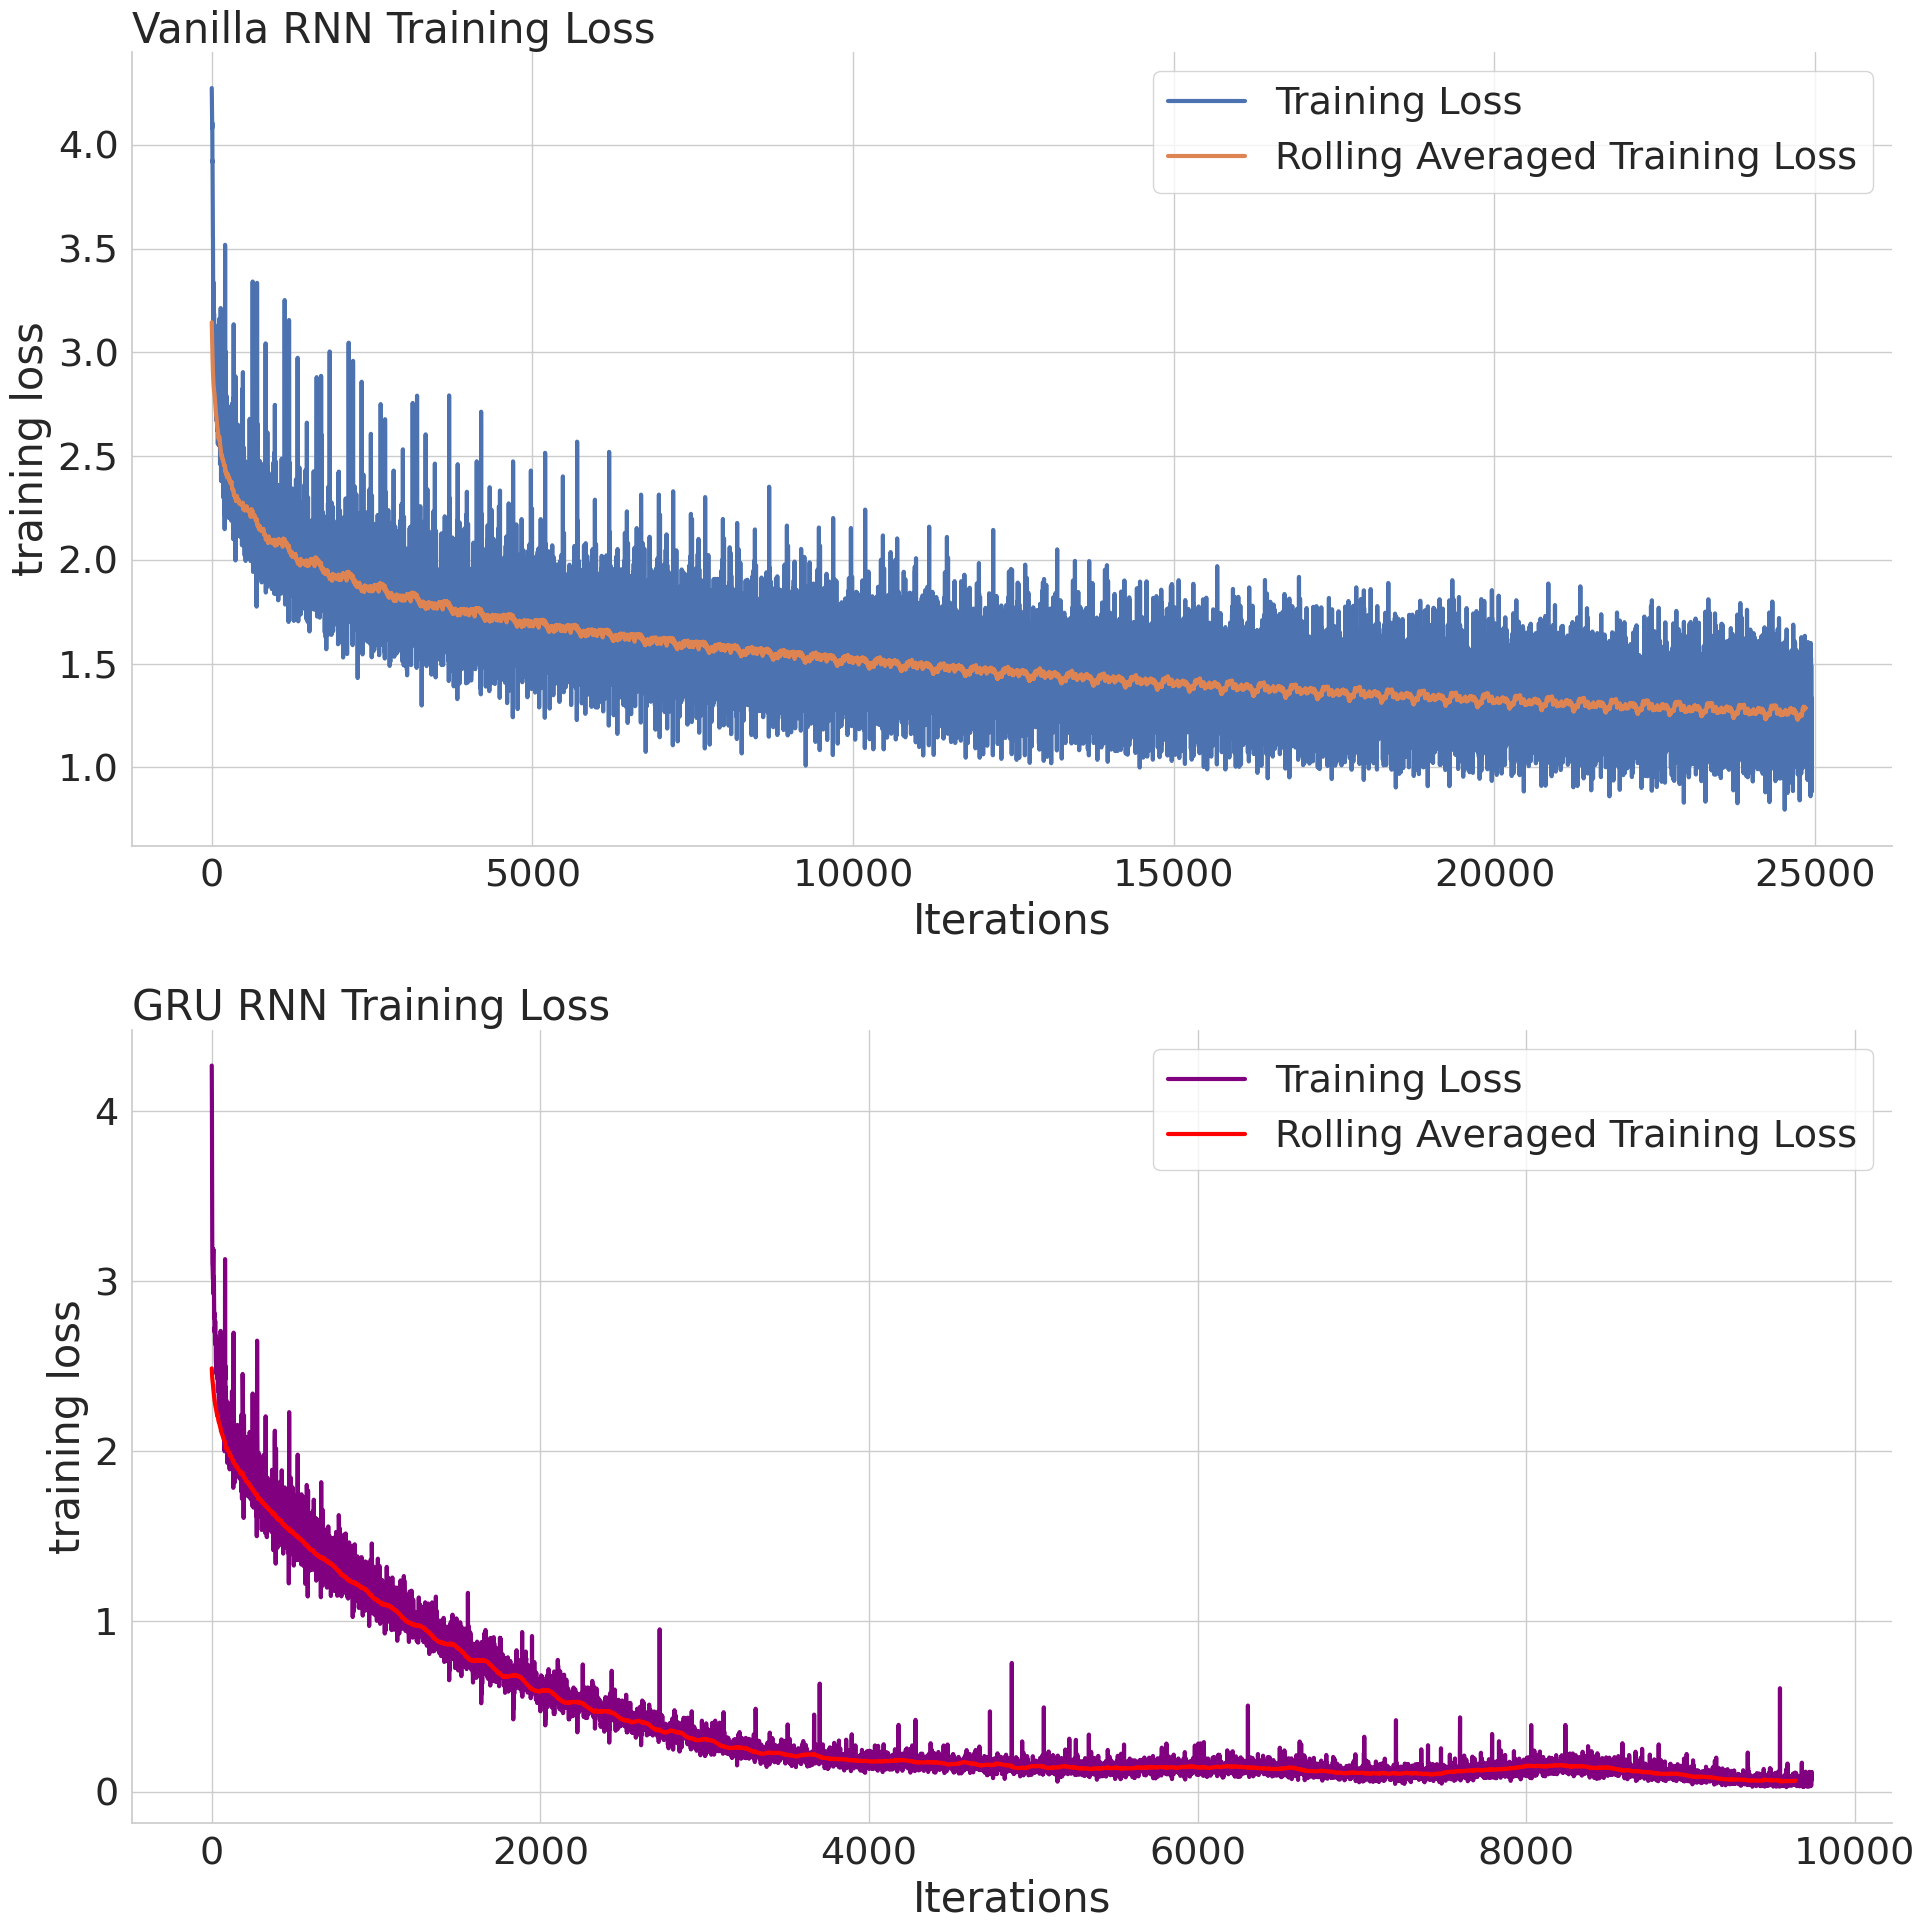

In [177]:
# Plot the training loss and rolling mean training loss with respect to iterations
# Feel free to change the window size
plt.figure(figsize = (20, 20))

plt.subplot(2, 1, 1)

plt.plot(training_loss, linewidth = 3, label = 'Training Loss')
plt.plot(np.convolve(training_loss, np.ones(100), 'valid') / 100,
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.title("Vanilla RNN Training Loss", loc='left')
plt.legend()
sns.despine()

plt.subplot(2, 1, 2)

plt.plot(training_loss_gru, linewidth = 3, label = 'Training Loss', color='purple')
plt.plot(np.convolve(training_loss_gru, np.ones(100), 'valid') / 100,
         linewidth = 3, label = 'Rolling Averaged Training Loss', color='red')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.title("GRU RNN Training Loss", loc='left')
plt.legend()
sns.despine()

plt.tight_layout()
plt.show()
